<img src="../logo_UTN.svg" align="right" width="200" /> 

# Tarea semanal 10
## Manuel Dieguez

# ¿Que vamos a estudiar en esta tarea?

En esta tarea vamos a probar algunos ejemplos de filtrado no lineal en nuestro ECG


In [83]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io.wavfile import write
import warnings
warnings.filterwarnings('ignore')

In [84]:
def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

##################
# Lectura de ECG #
##################

fs_ecg = 1000 # Frecuencia de muestreo del ECG en Hz
N = 40000     # Muestras a tomar del ECG
t = np.arange(0, N/fs_ecg, 1/fs_ecg)
#w = 10

# para listar las variables que hay en el archivo

mat_struct = sio.loadmat('./ECG_TP4.mat')

#ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
ecg_one_lead = mat_struct['ecg_lead'].flatten()
qrs_detections = mat_struct['qrs_detections'].flatten()
ecg_one_lead_cut = ecg_one_lead[0:N]

t_full = np.arange(0,len(ecg_one_lead)/fs_ecg, 1/fs_ecg)
ripple = 0.5
att = 40

fci = 0.5
fcs = 30
fsi = 0.1
fss = 45

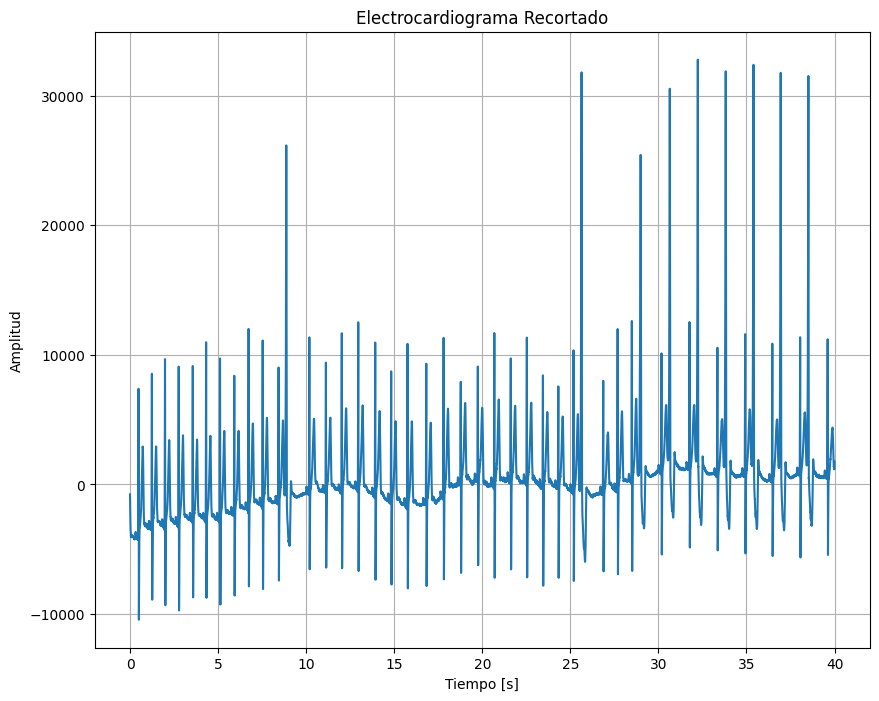

In [85]:
plt.figure(1, figsize=(10,8))
plt.title("Electrocardiograma Recortado")
plt.ylabel("Amplitud")
plt.xlabel("Tiempo [s]")
plt.plot(t,ecg_one_lead_cut)
#plt.plot(np.arange(0,N/fs_ecg,1/fs_ecg), ecg_one_lead_cut)
plt.grid()


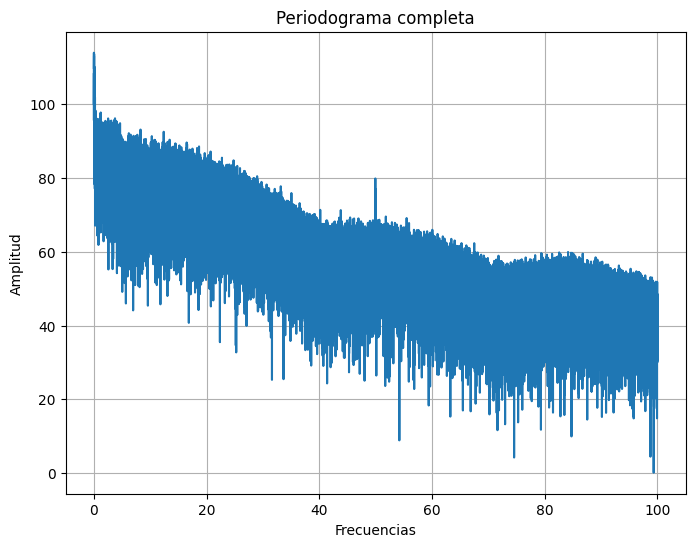

In [86]:
## Peridograma simple de la senal completa
freqs_full = np.fft.fftfreq(len(ecg_one_lead), d=1/fs_ecg)
fft_ecg_full = np.fft.fft(ecg_one_lead)
Pxx_ecg_full = np.abs(fft_ecg_full)**2/len(ecg_one_lead)
i = int(len(freqs_full)/2)
bool_index = (freqs_full >= 0) & (freqs_full <= 100)

plt.figure(2, figsize=(8,6))
plt.title("Periodograma completa")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_full[bool_index],10*np.log10(Pxx_ecg_full)[bool_index])
plt.grid()
plt.show()

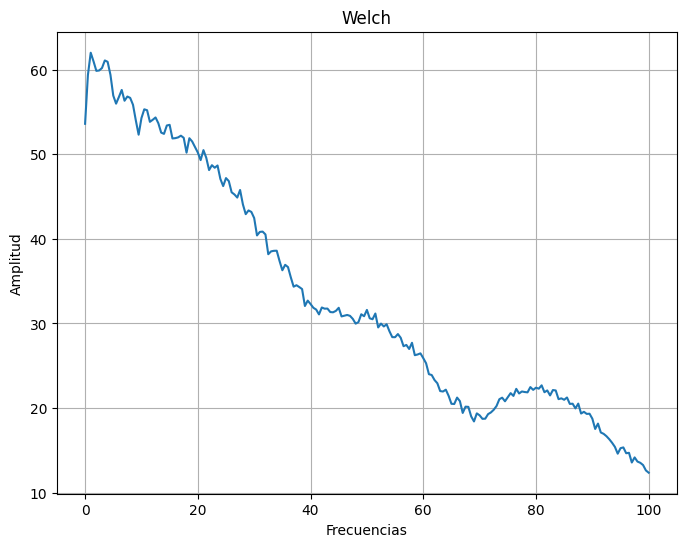

In [87]:
## Hacemos la estimacion de Welch para las primeras N muestras del ECG
w = 20
[freqs_welch, fft_welch] = sc.signal.welch(ecg_one_lead_cut, fs_ecg, window = "hann", nperseg = int(N/w), detrend ="linear") ## Detrend saca la pendiente , detrend ="linear"
bool_index = (freqs_welch >= 0) & (freqs_welch <= 100)

plt.figure(4, figsize = (8,6))
plt.title("Welch")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_welch[bool_index],10*np.log10(fft_welch)[bool_index])
plt.grid()
plt.show()

## Filtro de medianas

El filtro de medianas es un filtrado no lineal que utiliza las medianas de la senal para eliminar el ruido. 

El mismo se calcula con ventanas deslizantes en cada muestra, tomando una ventana de 200 muestras y quedandose con la media, luego al resultado se le vuelve a aplicar un filtro de mediana pero de 600 muestras, tal que:

$$ \hat{b} = \mathop{med}_{600} \{ \mathop{med}_{200} \{s\} \} $$

Luego, restamos el resultado a la senal de forma que:

$$ \hat{x} = s - \hat{b} $$

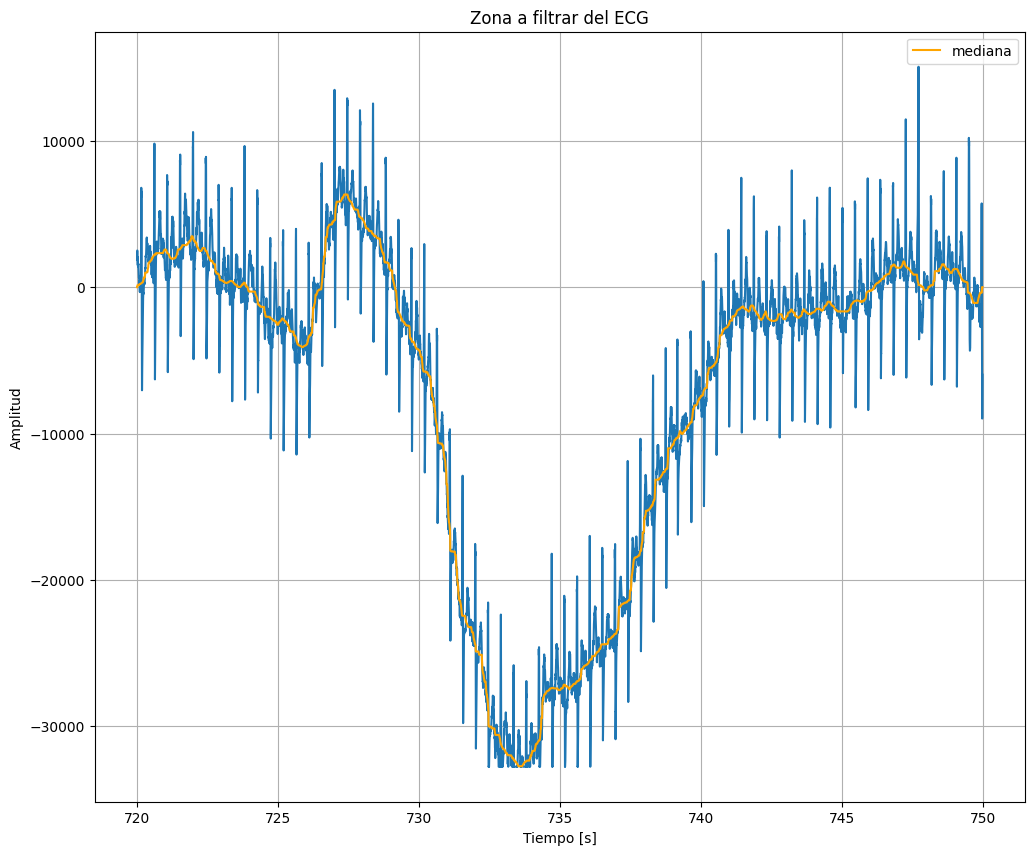

In [88]:
zoom_region = np.arange(720000,750000)
ecg_med = sc.signal.medfilt(sc.signal.medfilt(ecg_one_lead[zoom_region], 201),601)

plt.figure(5, figsize=(12,10))
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Zona a filtrar del ECG")
plt.plot(t_full[zoom_region],ecg_one_lead[zoom_region])
plt.plot(t_full[zoom_region], ecg_med,color ="orange", label='mediana')
plt.grid()
plt.legend()
plt.show()

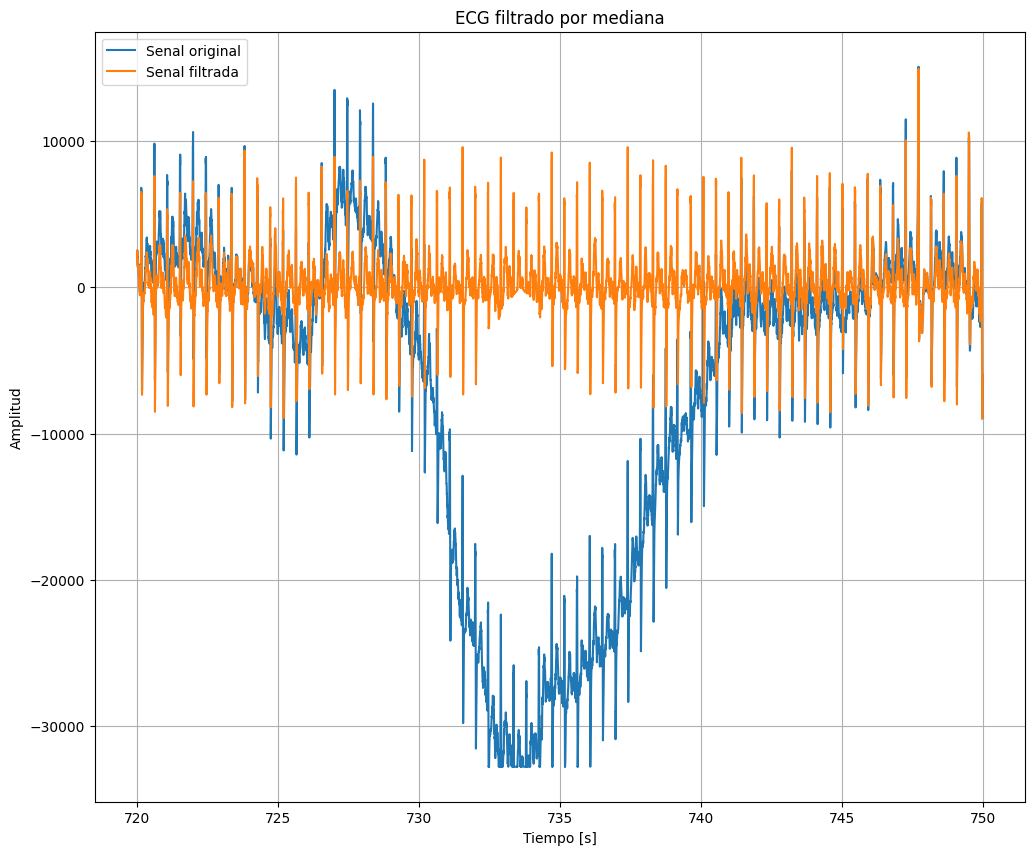

In [89]:
ecg_filt_med = ecg_one_lead[zoom_region] - ecg_med

plt.figure(6,  figsize=(12,10))
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("ECG filtrado por mediana")
plt.plot(t_full[zoom_region],ecg_one_lead[zoom_region], label = "Senal original")
plt.plot(t_full[zoom_region],ecg_filt_med, label = "Senal filtrada")
plt.legend()
plt.grid()
plt.show()

Podemos observar que el filtro fue sumamente efectivo para quitar la deriva de baja frecuencia, pero hay que tener en cuenta que este tipo de filtrado

## Filtrado con Cubi Spline

Un cubic spline es una técnica de interpolación que utiliza un conjunto de polinomios cúbicos por tramos para aproximar una función f(x) de manera suave entre un conjunto de puntos conocidos. A diferencia de los polinomios de alto grado, evitan oscilaciones excesivas y son precisos incluso con pocos datos. Esto tambien hace que sea menos costoso computacionalmente que un filtro de mediana

Para aplicarlo, vamos a usar la funcion de Scipy

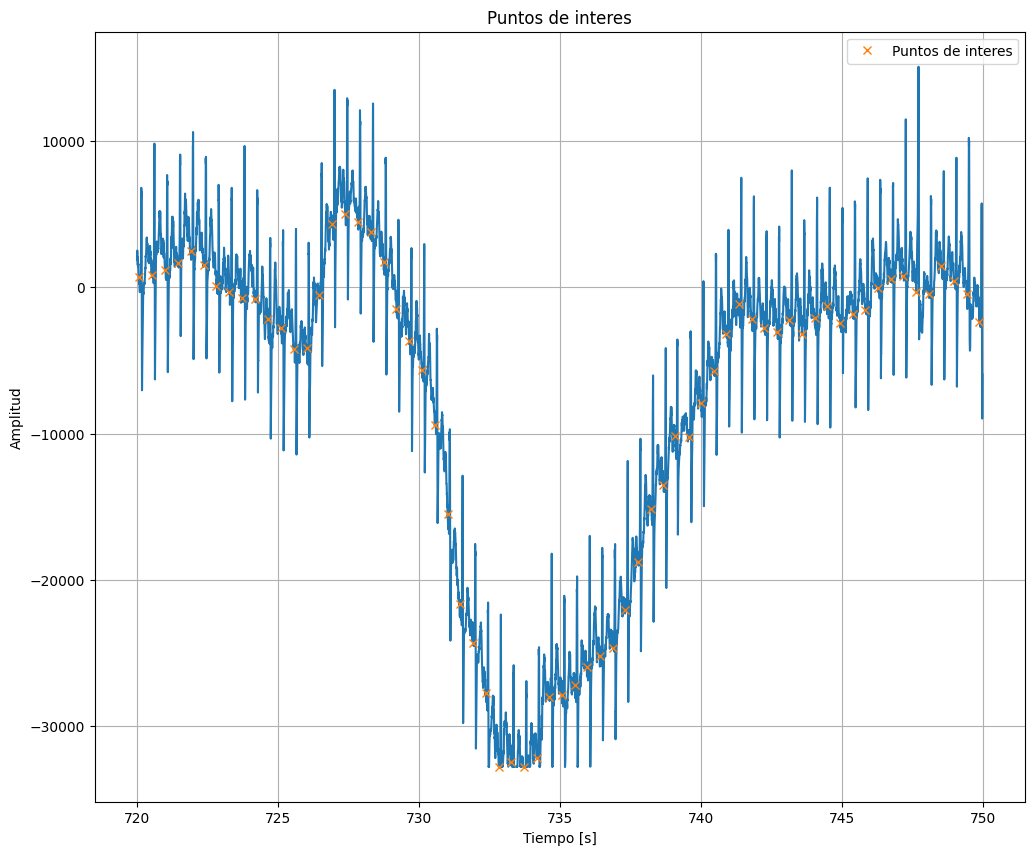

In [90]:
offset_ms = 80 ## Offset en milisegundos
offset_samples = int(offset_ms*1e-3*fs_ecg)

#marcas_qrs = qrs_detections[(qrs_detections >= zoom_region[0]) & (qrs_detections <= zoom_region[-1])] - offset_samples
marcas_qrs = qrs_detections - offset_samples
zoom_marcas = marcas_qrs[(marcas_qrs >= zoom_region[0]) & (marcas_qrs <= zoom_region[-1])]

plt.figure(7, figsize=(12,10))
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Puntos de interes")
plt.plot(t_full[zoom_region],ecg_one_lead[zoom_region])
plt.plot(t_full[zoom_marcas], ecg_one_lead[zoom_marcas], 'x', label='Puntos de interes')
plt.grid()
plt.legend()
plt.show()

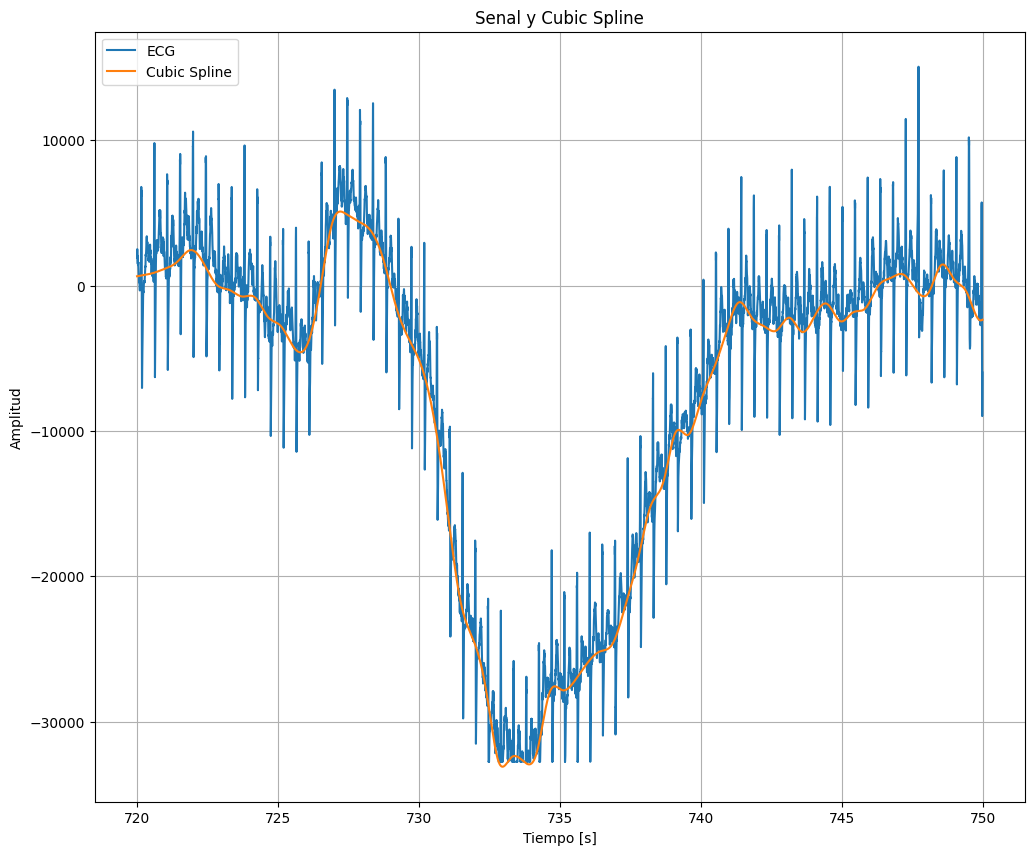

In [91]:
cubic_spl = sc.interpolate.CubicSpline(marcas_qrs, ecg_one_lead[marcas_qrs])
ecg_cubic = cubic_spl(zoom_region)

plt.figure(7, figsize=(12,10))
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Senal y Cubic Spline")
plt.plot(t_full[zoom_region],ecg_one_lead[zoom_region], label= "ECG")
plt.plot(t_full[zoom_region], ecg_cubic, label='Cubic Spline')
plt.grid()
plt.legend()
plt.show()

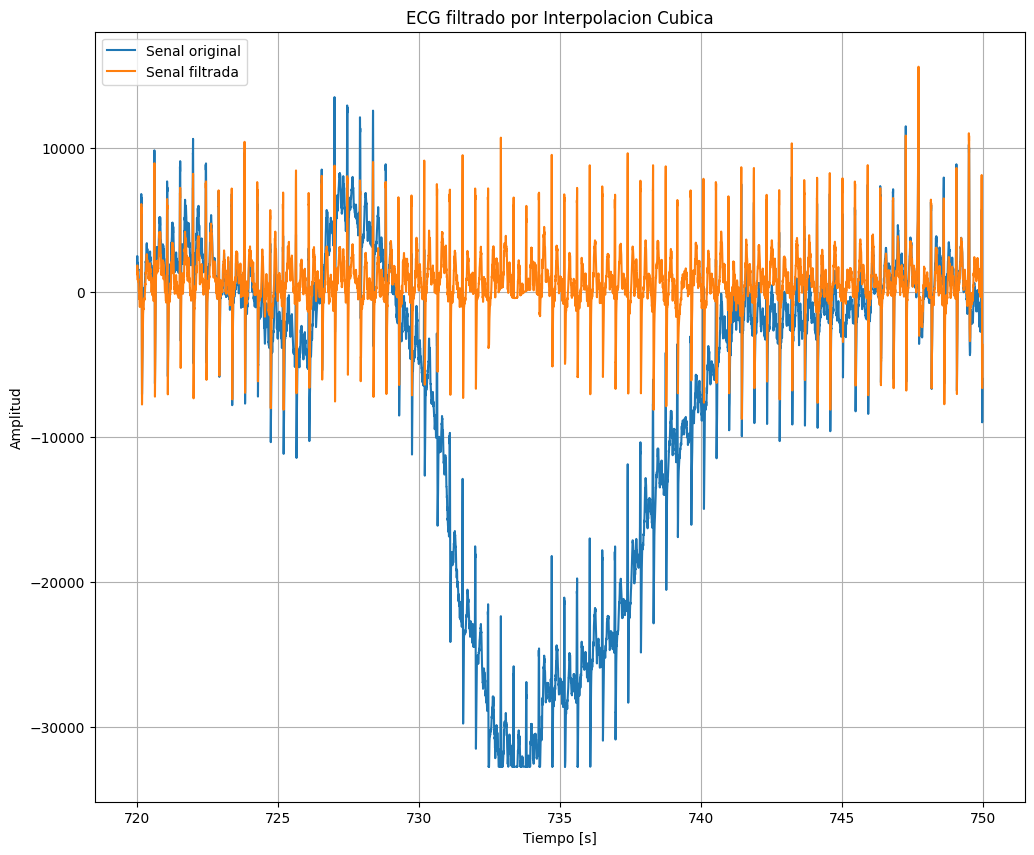

In [92]:
ecg_filt_cubic = ecg_one_lead[zoom_region] - ecg_cubic

plt.figure(9,  figsize=(12,10))
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("ECG filtrado por Interpolacion Cubica")
plt.plot(t_full[zoom_region],ecg_one_lead[zoom_region], label = "Senal original")
plt.plot(t_full[zoom_region],ecg_filt_cubic, label = "Senal filtrada")
plt.legend()
plt.grid()
plt.show()

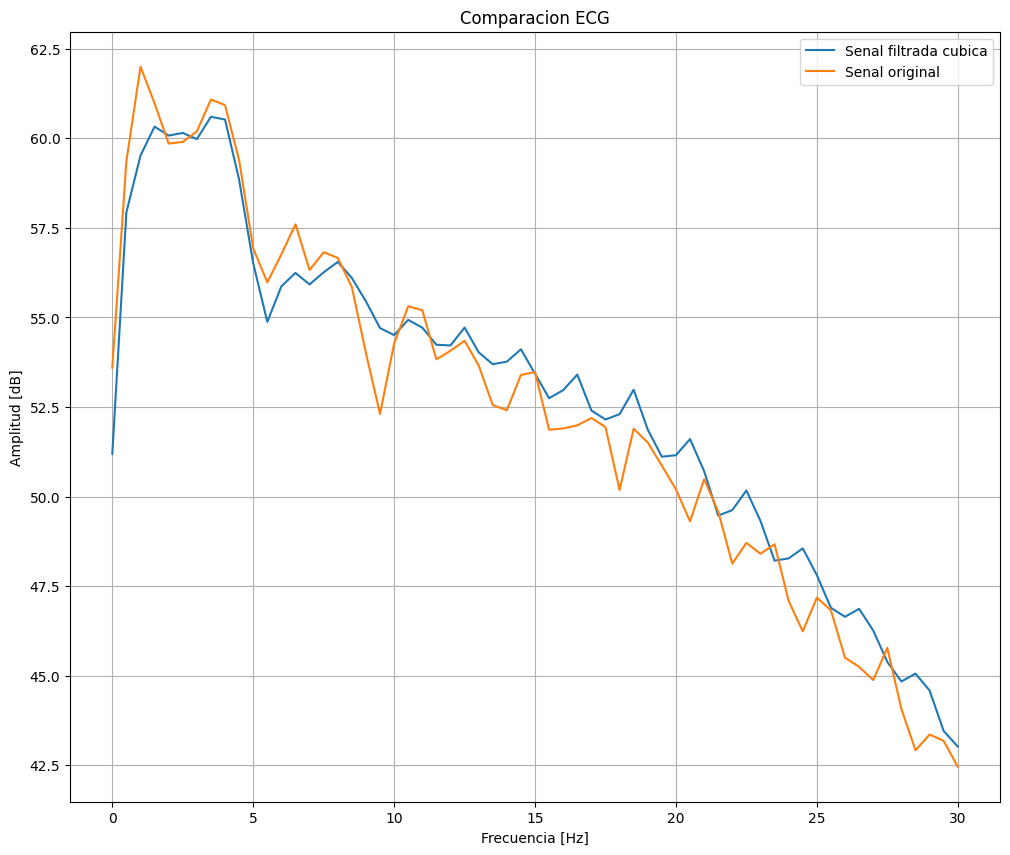

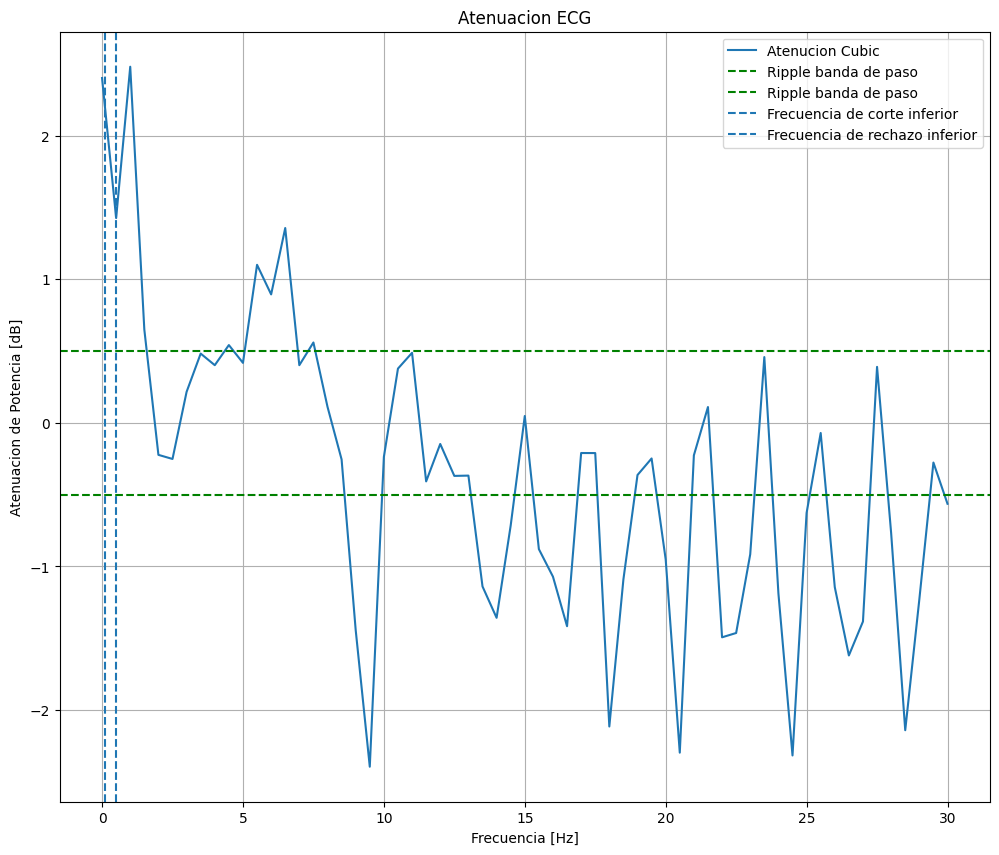

In [99]:
ecg_cubic_full = cubic_spl(np.arange(len(ecg_one_lead)))
ecg_filt_full = ecg_one_lead - ecg_cubic_full
[freqs_welch_cubic, fft_welch_cubic] = sc.signal.welch(ecg_filt_full, fs_ecg, window = "hann", nperseg = int(N/w)) ## Detrend saca la pendiente , detrend ="linear"

#ecg_filt_med = ecg_one_lead[zoom_region] - ecg_med
#[freqs_welch_med, fft_welch_med] = sc.signal.welch(ecg_filt_med, fs_ecg, window = "hann", nperseg = int(N/w)) ## Detrend saca la pendiente , detrend ="linear"

bool_index = (freqs_welch_cubic >= 0) & (freqs_welch_cubic <= 30)

atenuacion_cubic = np.abs(np.divide(fft_welch,fft_welch_cubic))
#atenuacion_med = np.abs(np.divide(fft_welch,fft_welch_med))

plt.figure(9,  figsize=(12,10))
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud [dB]")
plt.title("Comparacion ECG")
plt.plot(freqs_welch_cubic[bool_index], 10*np.log10(fft_welch_cubic[bool_index]), label = "Senal filtrada cubica")
#plt.plot(freqs_welch_cubic[bool_index], 10*np.log10(fft_welch_med[bool_index]), label = "Senal filtrada mediana")
plt.plot(freqs_welch_cubic[bool_index], 10*np.log10(fft_welch[bool_index]), label = "Senal original")
plt.legend()
plt.grid()
plt.show()

plt.figure(10,  figsize=(12,10))
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Atenuacion de Potencia [dB]")
plt.title("Atenuacion ECG")
plt.plot(freqs_welch_filt[bool_index], 10*np.log10(atenuacion_cubic[bool_index]), label ="Atenucion Cubic")
#plt.plot(freqs_welch_med[bool_index], 10*np.log10(atenuacion_med[bool_index]), label ="Atenucion Mediana")
plt.axhline(-ripple, color='green', linestyle='--', label="Ripple banda de paso")
plt.axhline(ripple, color='green', linestyle='--', label="Ripple banda de paso")
plt.axvline(fci,linestyle = '--', label = "Frecuencia de corte inferior")
plt.axvline(fsi,linestyle = '--', label = "Frecuencia de rechazo inferior")
plt.legend()
plt.grid()
plt.show()

## Conclusion

El filtro de medianas no solamente eliminó la deriva de la señal con mayor precisión, sino que también eliminó componentes más rápidas. Este seguimiento más preciso lo hace a costa de un procesamiento mayor en comparación con Cubic Spline, haciéndolo más difícil/costoso en señales con muchas muestras.

También vemos que es importante conocer la naturaleza de nuestra señal y en qué frecuencias tenemos información, ya que si nuestra señal tiene información en altas frecuencias, el método de filtrado por mediana nos podría hacer perder parte de la misma.

Además, podemos observar que en la banda de paso, zona donde esperamos que el filtro sea inocuo o que la atenuación/ganancia sea de 0 dB, el filtrado no lineal no cumple con el ripple planteado. Esto tiene sentido, ya que no es un parámetro de diseño en el filtrado no lineal, a diferencia del filtrado lineal. Esto hay que tenerlo en cuenta para evaluar cómo afecta a la señal y si nos hace perder información relevante de la misma.